# Лабораторная работа 4

In [82]:
from fastai.imports import *
from pathlib import Path
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import accuracy_score, classification_report

sns_palette = sns.color_palette("muted")


Выбрать подходящую таблицу данных (должна содержать числовые и категориальные переменные). 

https://github.com/ukishore33/Capstone-Project-on-Credit-Card-Dataset?ysclid=lq7zdefpwb926510614

In [83]:
df = pd.read_csv("Credit_card.csv")
labels = pd.read_csv("Credit_card_label.csv")
dep = 'Approved'

df[dep] = labels.label.astype(int)

df.loc[df[dep] == 1, 'Status'] = 'Approved'
df.loc[df[dep] == 0, 'Status'] = 'Declined'
print('Total records:', len(df))

Total records: 1548


In [84]:
df

,Ind_ID,GENDER,Car_Owner,Propert_Owner,CHILDREN,Annual_income,Type_Income,EDUCATION,Marital_status,Housing_type,Birthday_count,Employed_days,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Family_Members,Approved,Status
0,5008827,M,Y,Y,0,180000.0,Pensioner,Higher education,Married,House / apartment,-18772.0,365243,1,0,0,0,NaN,2,1,Approved
1,5009744,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,Approved
2,5009746,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,NaN,-586,1,1,1,0,NaN,2,1,Approved
3,5009749,F,Y,N,0,NaN,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,Approved
4,5009752,F,Y,N,0,315000.0,Commercial associate,Higher education,Married,House / apartment,-13557.0,-586,1,1,1,0,NaN,2,1,Approved
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,F,N,Y,0,NaN,Commercial associate,Higher education,Married,House / apartment,-11957.0,-2182,1,0,0,0,Managers,2,0,Declined
1544,5023655,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229.0,-1209,1,0,0,0,Accountants,1,0,Declined
1545,5115992,M,Y,Y,2,180000.0,Working,Higher education,Married,House / apartment,-13174.0,-2477,1,0,0,0,Managers,4,0,Declined
1546,5118219,M,Y,N,0,270000.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-15292.0,-645,1,1,1,0,Drivers,2,0,Declined


<Axes: >

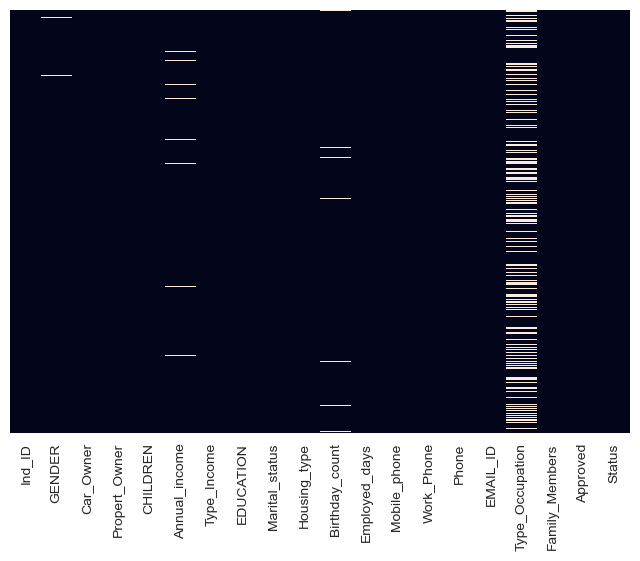

In [85]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

In [86]:
df.fillna(0, inplace=True)

In [87]:
df.dropna(inplace=True)

<Axes: >

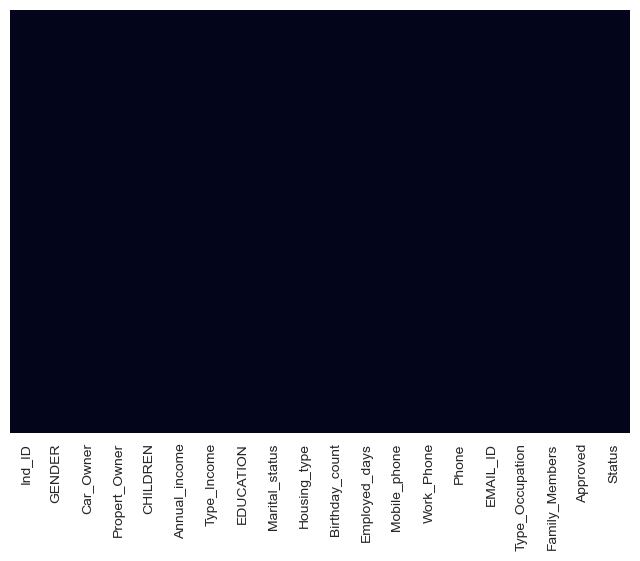

In [88]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)

В итоге избавились от 52 строки(3.36%)

In [94]:
cats = ['GENDER', 'Car_Owner', 'Propert_Owner', 'Type_Income',
    'EDUCATION', 'Marital_status', 'Housing_type', 'Mobile_phone',
    'Work_Phone', 'Phone', 'EMAIL_ID']

conts = ['CHILDREN', 'Family_Members', 'Annual_income',
    'Age', 'EmployedDaysOnly', 'UnemployedDaysOnly']


In [95]:
def proc_data():
    df['Age'] = -df.Birthday_count // 365
    df['EmployedDaysOnly'] = df.Employed_days.apply(lambda x: x if x > 0 else 0)
    df['UnemployedDaysOnly'] = df.Employed_days.apply(lambda x: abs(x) if x < 0 else 0)

    for cat in cats:
        df[cat] = pd.Categorical(df[cat])

    modes = df.mode().iloc[0]
    df.fillna(modes, inplace=True)

proc_data()

C:\Users\79132\AppData\Local\Temp\ipykernel_19224\3344553645.py:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.fillna(modes, inplace=True)


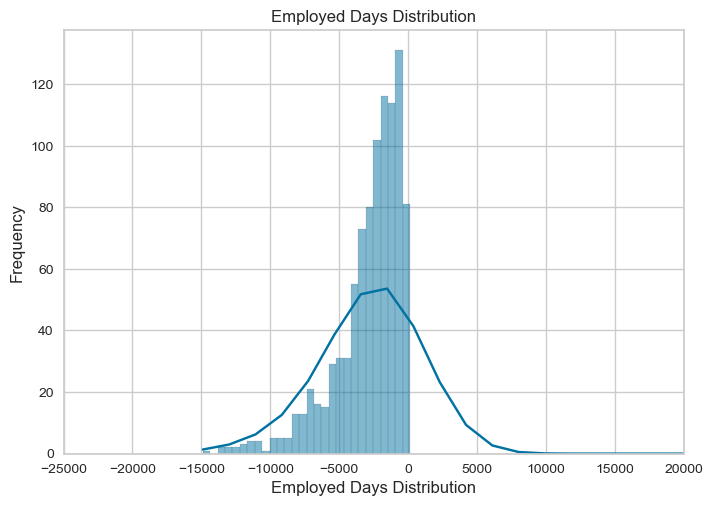

In [96]:
emp_days = df.Employed_days.value_counts().index
sns.histplot(x=emp_days, kde=True)
plt.xlabel('Employed Days Distribution')
plt.ylabel('Frequency')
plt.title('Employed Days Distribution')
plt.xlim(-25000, 20000);
#1:7

Временно убрать категориальные признаки. Оставить количественные и построить линейную регрессию. Построить решение методом бустинга. Сравнить с линейной регрессией.

In [97]:
df_nocats = df.drop(cats,axis=1)
df_nocats = df.drop('Status', axis = 1)

In [98]:
X, y = df_nocats[conts].copy(), df_nocats[dep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

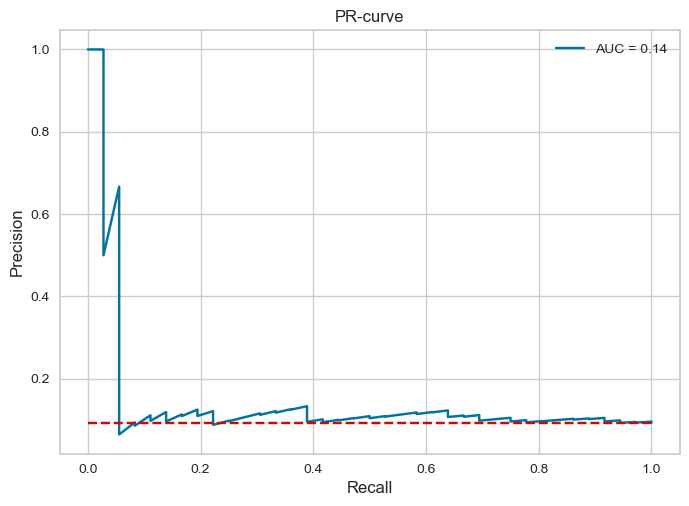

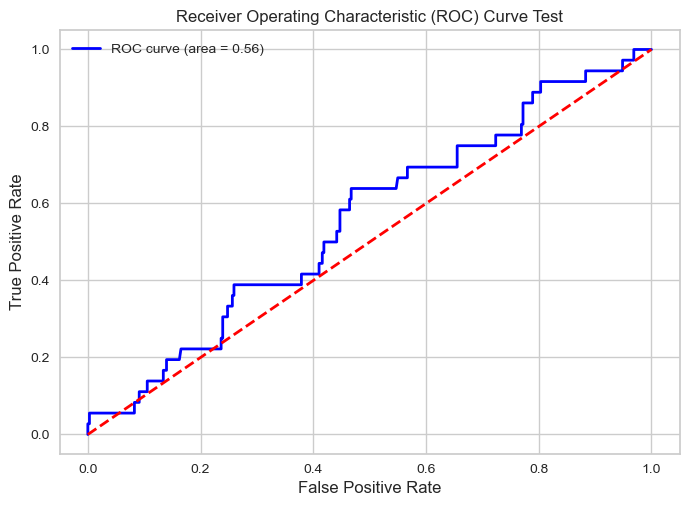

D:\conda\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
D:\conda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


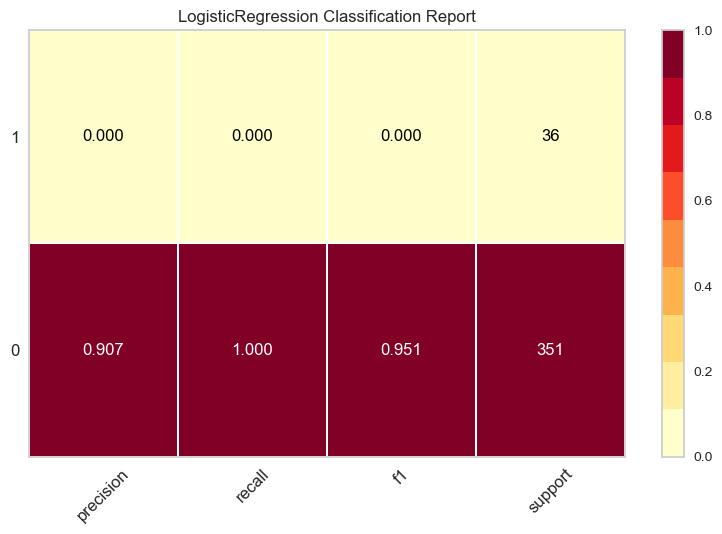

<Axes: title={'center': 'LogisticRegression Classification Report'}>

In [99]:
from matplotlib.colors import ListedColormap
from yellowbrick.classifier import ClassificationReport

from sklearn.linear_model import LinearRegression

lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

y_pred_lr = lr_classifier.predict_proba(X_test)[:,1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_lr)
pr_auc_lr = auc(recall_lr, precision_lr)

plt.title('PR-curve')
plt.plot(recall_lr, precision_lr, 'b', label = 'AUC = %0.2f' % pr_auc_lr)
noskill = len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1], [noskill, noskill],'r--')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_lr)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.legend()
plt.show()

y_pred = lr_classifier.predict(X_test)
vis = ClassificationReport(lr_classifier, classes=[0,1], support=True)
vis.score(X_test, y_test)       
vis.show() 


In [104]:
X, y = df_nocats.drop('UnemployedDaysOnly', axis = 1).copy(), df_nocats['UnemployedDaysOnly']
X = X.astype(str)
transformed = ohe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.25,random_state=42)

In [106]:

from sklearn.model_selection import GridSearchCV

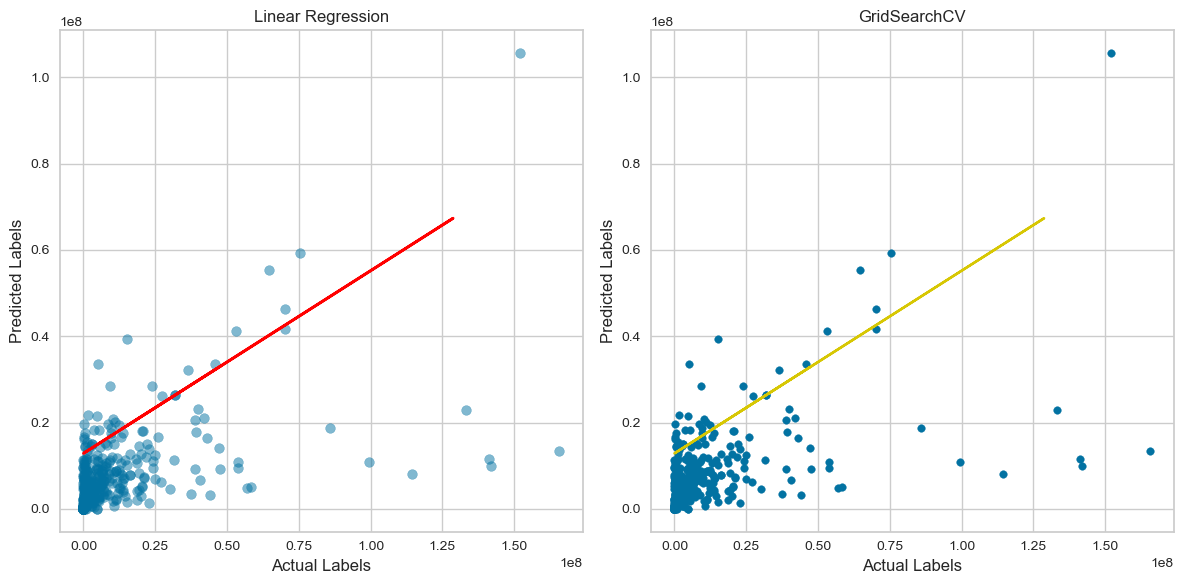

In [134]:
param_grid = {'fit_intercept': [True, False]}

lr_model = LinearRegression()

grid_search = GridSearchCV(lr_model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

lr_model.fit(X_train, y_train)
lrpred = lr_model.predict(X_test)
grpred = grid_search.predict(X_test)

df = {"label": y_test, "lr_predict": lrpred, "grid_search_pred": grpred}
df = pd.DataFrame(data=df)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_boost = best_model.predict(X_test)

n = np.size(y_test)
m_x = np.mean(y_test)
m_y = np.mean(y_pred_boost)
SS_xy = np.sum(y_pred_boost*y_test) - n*m_y*m_x
SS_xx = np.sum(y_test*y_test) - n*m_x*m_x
b_1 = SS_xy / SS_xx
b_0 = m_y - b_1*m_x
b = (b_0, b_1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test**2, lrpred**2, alpha=0.5)
plt.title('Linear Regression')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
# Adding separating line for Linear Regression
slope_lr, intercept_lr = np.polyfit(y_test, lrpred, 1)
plt.plot(y_test*10000, (slope_lr * y_test + intercept_lr)*10000, color='red', linewidth=2)

# Scatter plot for Gradient Boosting
plt.subplot(1, 2, 2)
plt.scatter(y_test**2, y_pred_boost**2, marker = "o", s = 30)
y_pred_1 = b[0] + b[1]*y_test
plt.plot(y_test*10000, y_pred_1*10000, color = "y")
plt.title('GridSearchCV')
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")

plt.tight_layout()
plt.show()

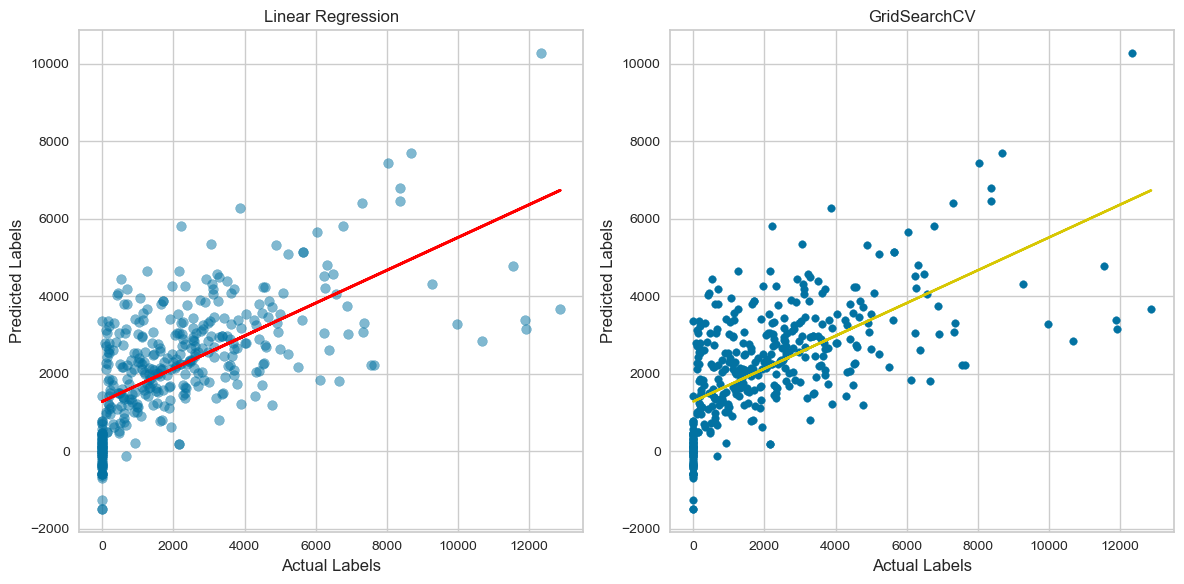

In [135]:
param_grid = {'fit_intercept': [True, False]}

lr_model = LinearRegression()

grid_search = GridSearchCV(lr_model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

lr_model.fit(X_train, y_train)
lrpred = lr_model.predict(X_test)
grpred = grid_search.predict(X_test)

df = {"label": y_test, "lr_predict": lrpred, "grid_search_pred": grpred}
df = pd.DataFrame(data=df)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_boost = best_model.predict(X_test)

n = np.size(y_test)
m_x = np.mean(y_test)
m_y = np.mean(y_pred_boost)
SS_xy = np.sum(y_pred_boost*y_test) - n*m_y*m_x
SS_xx = np.sum(y_test*y_test) - n*m_x*m_x
b_1 = SS_xy / SS_xx
b_0 = m_y - b_1*m_x
b = (b_0, b_1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, lrpred, alpha=0.5)
plt.title('Linear Regression')
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')

# Adding separating line for Linear Regression
slope_lr, intercept_lr = np.polyfit(y_test, lrpred, 1)
plt.plot(y_test, (slope_lr * y_test + intercept_lr), color='red', linewidth=2)

# Scatter plot for Gradient Boosting
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_boost, marker = "o", s = 30)
y_pred_1 = b[0] + b[1]*y_test
plt.plot(y_test, y_pred_1, color = "y")
plt.title('GridSearchCV')
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")

plt.tight_layout()
plt.show()

AUC: 0.32454854843722347


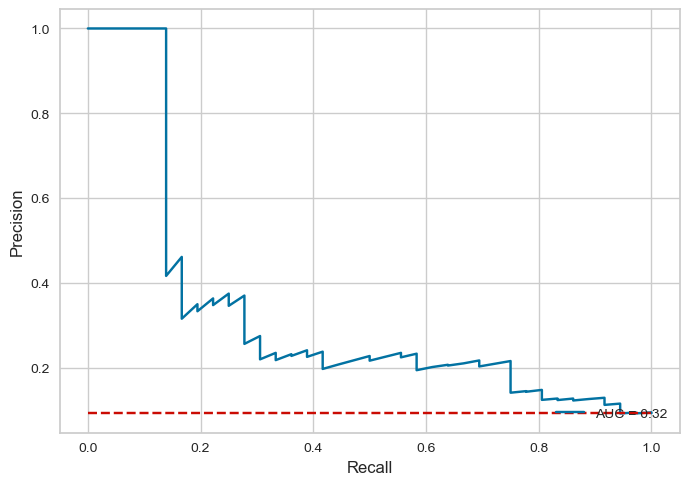

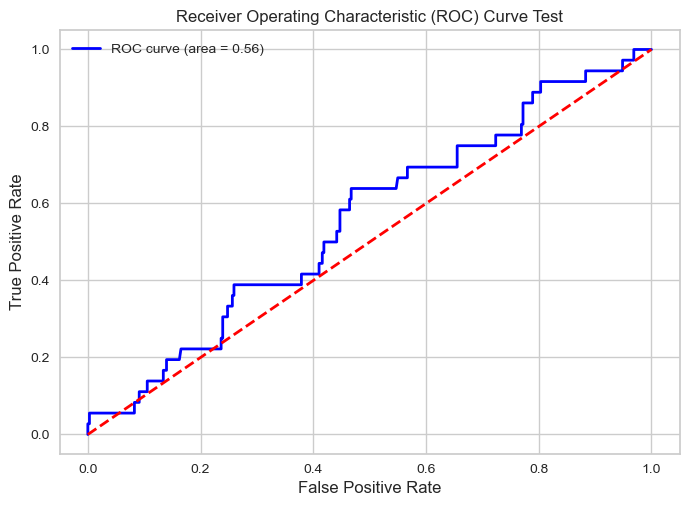

D:\conda\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


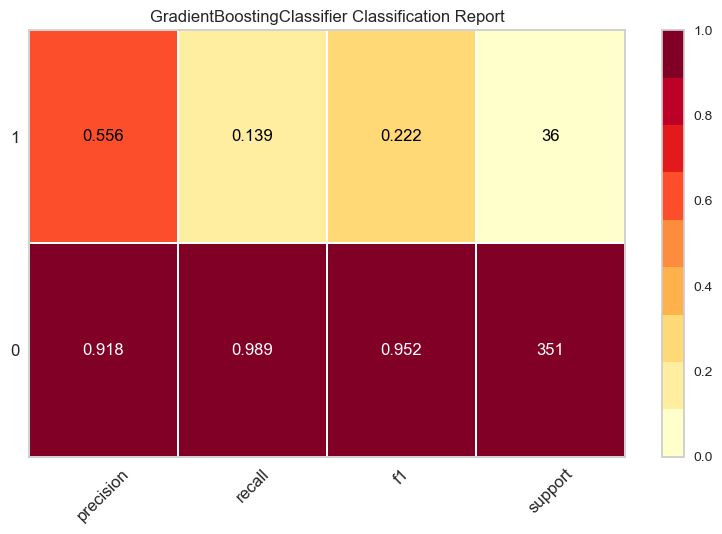

<Axes: title={'center': 'GradientBoostingClassifier Classification Report'}>

In [67]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_test)[:,1]

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f"AUC: {pr_auc}")
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
noskill = len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1], [noskill, noskill],'r--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()



fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_lr)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.legend()
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.show()
y_pred = model.predict(X_test)
vis = ClassificationReport(model, classes=[0,1], support=True)
vis.score(X_test, y_test)       
vis.show() 


3. Применить one hot и target encoding для категориальных признаков (взять данные,
где такие признаки есть). Сравнить точность.

In [102]:
df_noconts = df.drop(conts,axis=1)
df_noconts = df.drop(["Birthday_count","Employed_days","Annual_income","Age","EmployedDaysOnly","UnemployedDaysOnly","Status","Family_Members","CHILDREN"],axis=1)
df_noconts


,Ind_ID,GENDER,Car_Owner,Propert_Owner,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID,Type_Occupation,Approved
0,5008827,M,Y,Y,Pensioner,Higher education,Married,House / apartment,1,0,0,0,0,1
1,5009744,F,Y,N,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,0,1
2,5009746,F,Y,N,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,0,1
3,5009749,F,Y,N,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,0,1
4,5009752,F,Y,N,Commercial associate,Higher education,Married,House / apartment,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1543,5028645,F,N,Y,Commercial associate,Higher education,Married,House / apartment,1,0,0,0,Managers,0
1544,5023655,F,N,N,Commercial associate,Incomplete higher,Single / not married,House / apartment,1,0,0,0,Accountants,0
1545,5115992,M,Y,Y,Working,Higher education,Married,House / apartment,1,0,0,0,Managers,0
1546,5118219,M,Y,N,Working,Secondary / secondary special,Civil marriage,House / apartment,1,1,1,0,Drivers,0


# OneHotEncoder

In [144]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=df['Status'].value_counts().index, y=df['Approved'].value_counts().values)
plt.title('Number of Approved and Declined')
plt.ylabel('Count');

KeyError: 'Status'

<Figure size 1000x500 with 0 Axes>

In [145]:
ohe = OneHotEncoder()
X, y = df_noconts[cats].copy(), df_noconts[dep]
X = X.astype(str)
transformed = ohe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.25,random_state=42)


In [18]:
print(X_train)

  (0, 2)	1.0
  (0, 4)	1.0
  (0, 6)	1.0
  (0, 10)	1.0
  (0, 15)	1.0
  (0, 17)	1.0
  (0, 22)	1.0
  (0, 27)	1.0
  (0, 29)	1.0
  (0, 31)	1.0
  (0, 32)	1.0
  (1, 2)	1.0
  (1, 4)	1.0
  (1, 5)	1.0
  (1, 10)	1.0
  (1, 12)	1.0
  (1, 17)	1.0
  (1, 22)	1.0
  (1, 27)	1.0
  (1, 28)	1.0
  (1, 30)	1.0
  (1, 32)	1.0
  (2, 1)	1.0
  (2, 3)	1.0
  (2, 5)	1.0
  :	:
  (1158, 28)	1.0
  (1158, 31)	1.0
  (1158, 32)	1.0
  (1159, 1)	1.0
  (1159, 3)	1.0
  (1159, 6)	1.0
  (1159, 10)	1.0
  (1159, 12)	1.0
  (1159, 17)	1.0
  (1159, 22)	1.0
  (1159, 27)	1.0
  (1159, 28)	1.0
  (1159, 30)	1.0
  (1159, 32)	1.0
  (1160, 1)	1.0
  (1160, 4)	1.0
  (1160, 6)	1.0
  (1160, 10)	1.0
  (1160, 12)	1.0
  (1160, 17)	1.0
  (1160, 22)	1.0
  (1160, 27)	1.0
  (1160, 29)	1.0
  (1160, 31)	1.0
  (1160, 32)	1.0


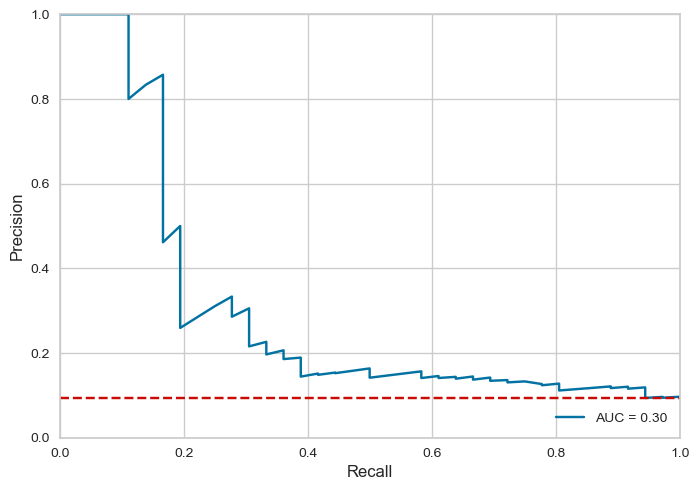

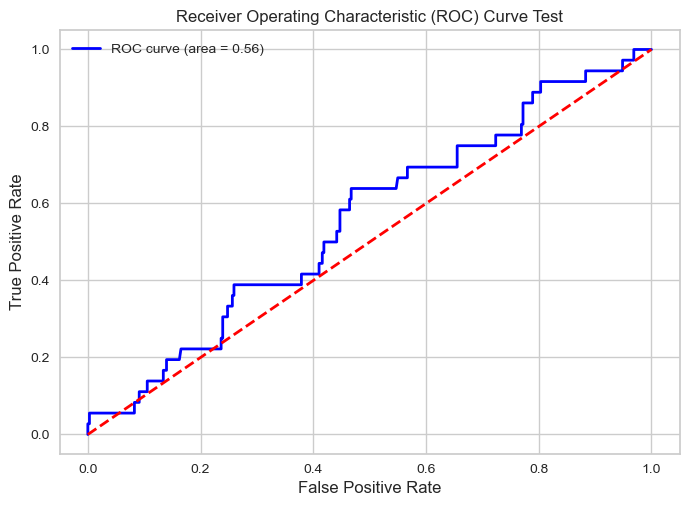

D:\conda\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


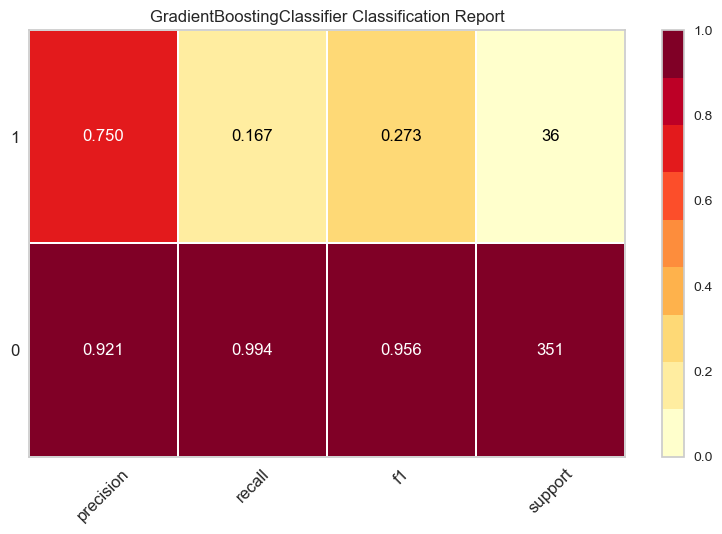

<Axes: title={'center': 'GradientBoostingClassifier Classification Report'}>

In [19]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
# Предсказание на тестовом наборе
y_pred = model.predict_proba(X_test)[:,1]

# Оценка точности
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
noskill = len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1], [noskill, noskill],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()



fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_lr)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.legend()
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.show()
y_pred = model.predict(X_test)
vis = ClassificationReport(model, classes=[0,1], support=True)
vis.score(X_test, y_test)       
vis.show() 


# LabelEncoder

In [118]:
X, y = df[cats + conts].copy(), df[dep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

X_train[cats] = X_train[cats].apply(lambda x: x.cat.codes)
X_test[cats] = X_test[cats].apply(lambda x: x.cat.codes)

In [21]:
X_train[cats]

,GENDER,Car_Owner,Propert_Owner,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID
1197,2,1,1,3,4,1,1,0,1,1,0
416,2,1,0,3,1,1,1,0,0,0,0
1234,1,0,0,1,4,1,1,0,0,0,0
31,1,0,1,1,4,1,1,0,0,1,1
583,1,0,1,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1130,1,0,0,0,1,1,1,0,1,1,1
1294,2,1,1,3,4,1,1,0,1,0,0
860,2,1,0,3,4,1,1,0,0,1,0
1459,1,0,1,3,1,1,1,0,0,0,0


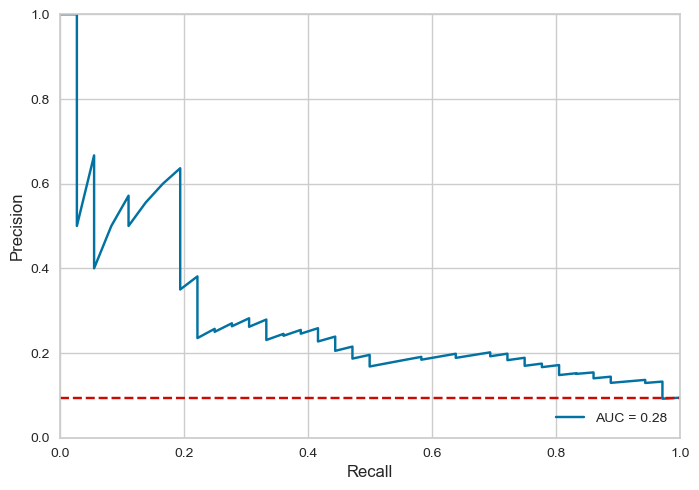

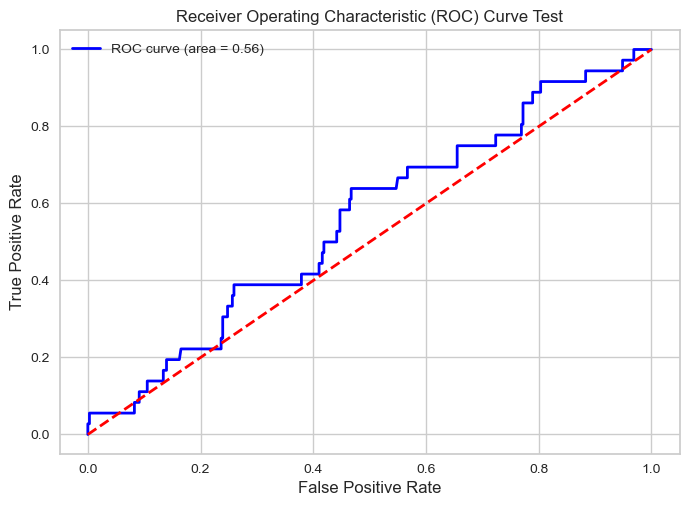

D:\conda\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


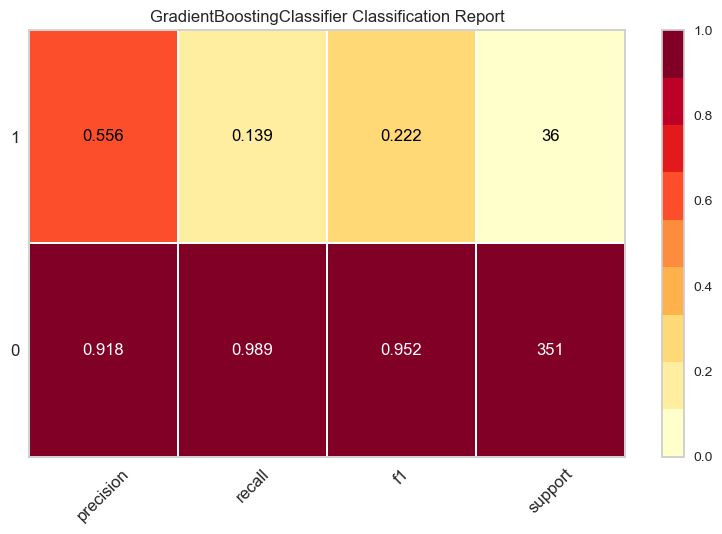

<Axes: title={'center': 'GradientBoostingClassifier Classification Report'}>

In [22]:
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
# Предсказание на тестовом наборе
y_pred = model.predict_proba(X_test)[:,1]

# Оценка точности
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
noskill = len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1], [noskill, noskill],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()



fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_lr)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.legend()
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.show()
y_pred = model.predict(X_test)
vis = ClassificationReport(model, classes=[0,1], support=True)
vis.score(X_test, y_test)       
vis.show() 

# TargetEncoder

In [147]:
import statsmodels.api as sm
import category_encoders as ce


y = df[dep]
X = df[cats]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1066)

KeyError: 'Approved'

In [148]:
encoder = ce.TargetEncoder(return_df=True)
X_train_loo = encoder.fit_transform(X_train, y_train)
X_test_loo = encoder.transform(X_test)
X_train_loo.describe()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
count,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,...,1161.000000,1161.000000,1161.000000,1161.0,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000,1161.000000
mean,0.005168,0.630491,0.364341,0.604651,0.395349,0.347976,0.652024,0.235142,0.177433,0.078381,...,0.004307,0.013781,0.045650,1.0,0.783807,0.216193,0.694229,0.305771,0.907838,0.092162
std,0.071733,0.482880,0.481452,0.489136,0.489136,0.476534,0.476534,0.424270,0.382200,0.268886,...,0.065512,0.116632,0.208815,0.0,0.411825,0.411825,0.460932,0.460932,0.289379,0.289379
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
X_test_loo

,GENDER,Car_Owner,Propert_Owner,Type_Income,EDUCATION,Marital_status,Housing_type,Mobile_phone,Work_Phone,Phone,EMAIL_ID
343,0.099612,0.118919,0.111386,0.171171,0.108241,0.146739,0.107078,0.113893,0.115189,0.113318,0.111307
576,0.130435,0.106426,0.118605,0.095087,0.108241,0.173469,0.107078,0.113893,0.115189,0.115183,0.111307
791,0.130435,0.106426,0.118605,0.095087,0.108241,0.110190,0.107078,0.113893,0.115189,0.113318,0.111307
931,0.099612,0.118919,0.111386,0.171171,0.108241,0.110190,0.107078,0.113893,0.115189,0.113318,0.111307
16,0.130435,0.118919,0.111386,0.095087,0.108241,0.146739,0.107078,0.113893,0.115189,0.113318,0.111307
...,...,...,...,...,...,...,...,...,...,...,...
20,0.130435,0.118919,0.118605,0.095087,0.129577,0.146739,0.107078,0.113893,0.115189,0.113318,0.111307
286,0.099612,0.118919,0.111386,0.127586,0.075360,0.110190,0.107078,0.113893,0.108949,0.115183,0.111307
1160,0.099612,0.118919,0.118605,0.095087,0.129577,0.110190,0.107078,0.113893,0.115189,0.113318,0.111307
1109,0.130435,0.106426,0.111386,0.095087,0.108241,0.110190,0.107078,0.113893,0.115189,0.113318,0.111307


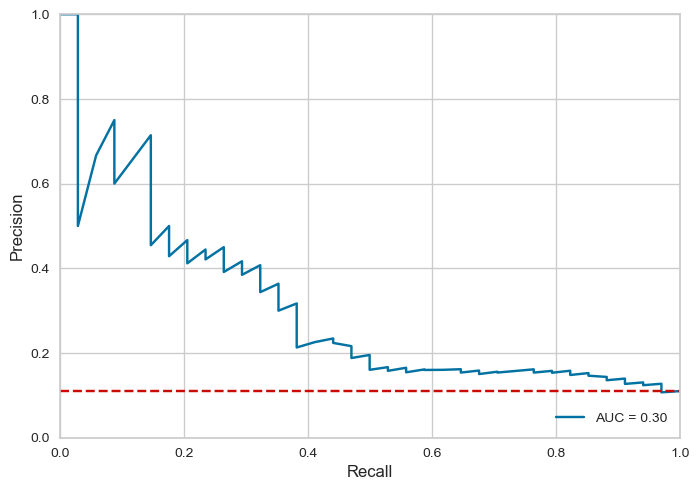

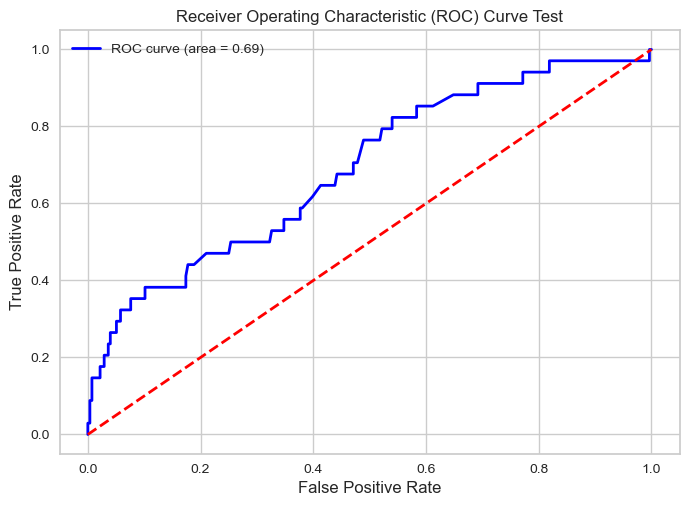

D:\conda\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


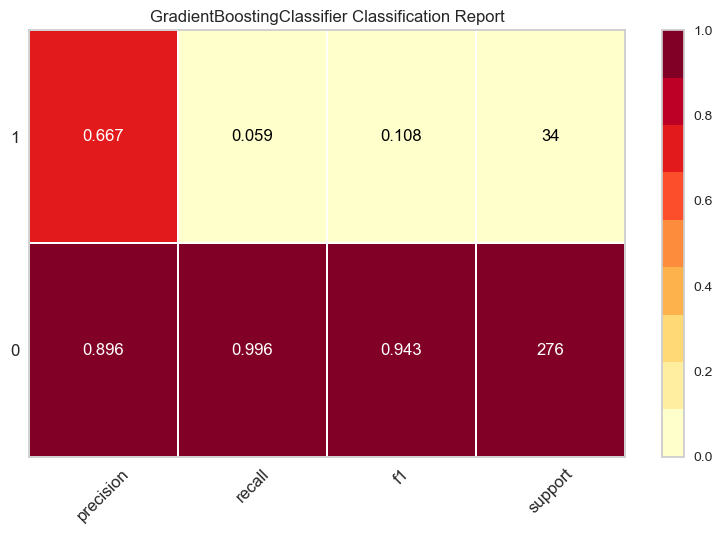

<Axes: title={'center': 'GradientBoostingClassifier Classification Report'}>

In [75]:

from yellowbrick.classifier import ClassificationReport
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_loo, y_train)
# Предсказание на тестовом наборе
y_pred = model.predict_proba(X_test_loo)[:,1]

# Оценка точности
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, 'b', label = 'AUC = %0.2f' % pr_auc)
plt.legend(loc = 'lower right')
noskill = len(y_test[y_test==1])/len(y_test)
plt.plot([0, 1], [noskill, noskill],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()



fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.legend()
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Test')
plt.show()
y_pred = model.predict(X_test_loo)
vis = ClassificationReport(model, classes=[0,1], support=True)
vis.score(X_test_loo, y_test)       
vis.show() 

Визуализировать объекты в пространстве главных компонент.

In [146]:
ohe = OneHotEncoder()
X, y = df_noconts[cats].copy(), df_noconts[dep]
X = X.astype(str)
transformed = ohe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(transformed, y, test_size=0.25,random_state=42)


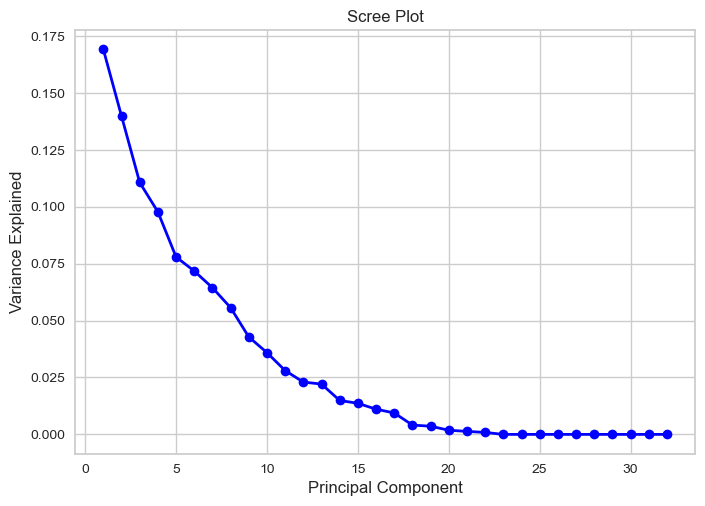

In [151]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=32)

#fit PCA model to data
pca_fit = pca.fit(X_train_loo)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [140]:
X, y = df[conts].copy(), df[dep]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25,random_state=42)

In [141]:
from matplotlib.text import Annotation
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D

class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)


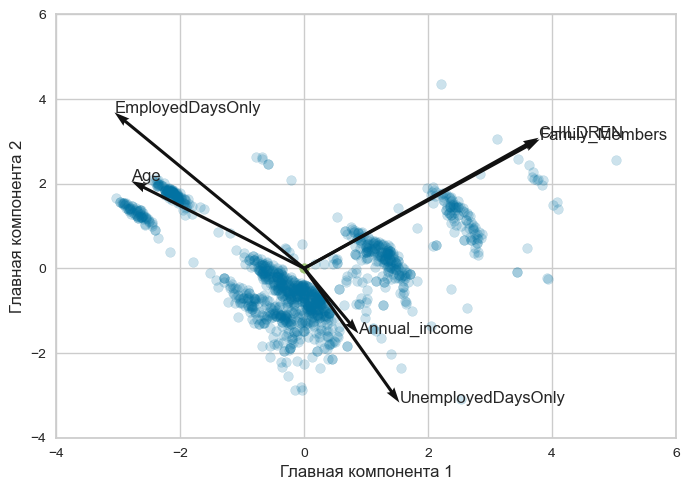

In [163]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

componetns_scale = 7

scaler = StandardScaler()
pca = PCA(n_components=2)

X_train_norm = scaler.fit_transform(X_train)
X_pca = pca.fit_transform(X_train_norm)
pca_components = pca.components_[:2, :]
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
plt.scatter(0, 0)
for i, feature in enumerate(X.columns):
    plt.quiver(0, 0, pca_components[0, i]*componetns_scale, pca_components[1, i]*componetns_scale, angles='xy', scale_units='xy', scale=1, width=0.005)
    plt.annotate(feature, (pca_components[0, i]*componetns_scale, pca_components[1, i]*componetns_scale))

plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.ylim(-4,6)
plt.xlim(-4,6)
plt.show()


In [17]:
from sklearn.compose import ColumnTransformer

C:\Users\79132\AppData\Local\Temp\ipykernel_19224\3968406440.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(x='PC1', y='PC2', cmap='viridis', data=X_train_loo)
C:\Users\79132\AppData\Local\Temp\ipykernel_19224\3968406440.py:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


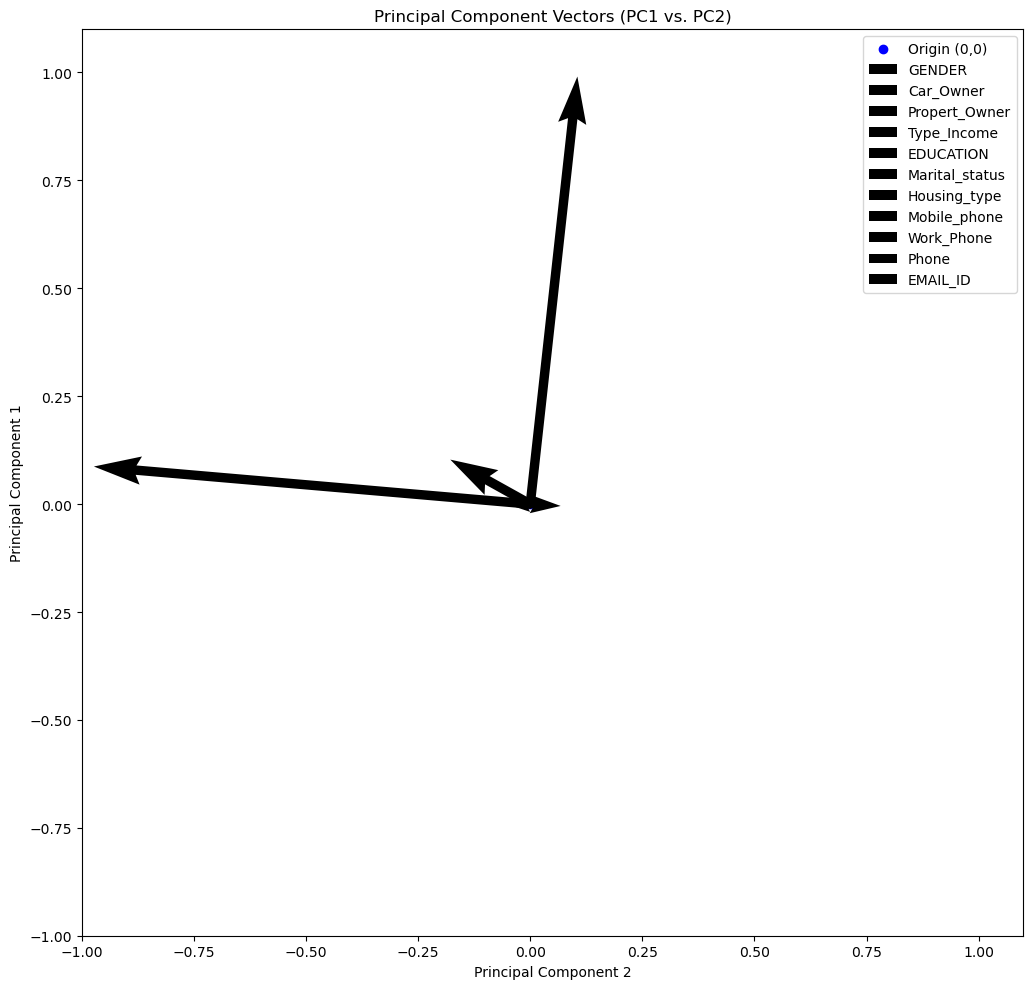

In [49]:
scaler = StandardScaler()
pca = PCA(n_components=7)

X_train_norm = scaler.fit_transform(X_train_loo)
X = pca.fit_transform(X_train_loo)
components = pca.components_[:2, :]

len_components = np.arange(pca.n_components_) + 1
categorical_columns = cats
feature_names = cats + conts

for i in range(1, components.shape[0]):
    plt.figure(figsize=(20, 10))
    scatter = plt.scatter(x='PC1', y='PC2', cmap='viridis', data=X_train_loo)
    plt.title(f'Visualization of Objects in Principal Component Space (PC1 vs. PC2)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Type_Occupation')

    plt.subplot(1, 2, 2)
    plt.scatter(0, 0, marker='o', color='b', label='Origin (0,0)')

    for j, (comp1, comp2, feature_name) in enumerate(zip(components[i, :], components[0, :], feature_names)):
        plt.quiver(0, 0, comp1, comp2, angles='xy', scale_units='xy', scale=1,width=0.01, label=f"{feature_name}")

    plt.title(f'Principal Component Vectors (PC1 vs. PC{i + 1})')
    plt.ylabel('Principal Component 1')
    plt.xlabel(f'Principal Component {i + 1}')
    plt.legend()
    plt.ylim(-1, 1.1)
    plt.xlim(-1, 1.1)
    plt.tight_layout()

    plt.show()